1. Read data
2. Converting string to integer
3. Replacing NA values with mean of the column

In [3]:
import numpy as np
import pandas as pd

import sklearn.linear_model as sk

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import plotly.express as px


pd.set_option('max_columns', None)

#reading data and removing Nan values
data = pd.read_csv('C:\\studies\\first sem docs\\BIGDATA\\bankruptcy_prediction\\FinancialDataSet.csv', usecols=np.r_[0:66])
#converting object to float
for col in data.columns: 
    data[col] = pd.to_numeric(data[col], errors='coerce')
#replacing NAN values with mean of column    
data=data.fillna(data.mean())


C:\Users\bhagy\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (1,2,3,6,7,9,10,11,13,14,15,18,19,20,22,23,24,25,29,30,31,35,36,38,39,42,43,44,48,49,51,55,56,57,58,59,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


plot to show class imbalance

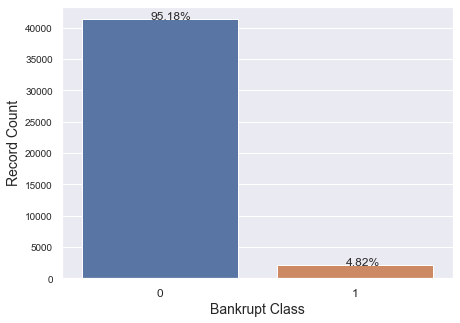

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()
 
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=data['class'],data=data)
plt.xticks(size=12)
plt.xlabel("Bankrupt Class", size=14)
plt.yticks(size=10)
plt.ylabel("Record Count", size=14)
 
without_hue(ax, data['class'])

Balancing data using random oversampling

In [ ]:
 def randomoversampling(df):
     bankrupt = df[df['class']==1]
     non_bankrupt = df[df['class']==0]
    # Normal_sample = Normal.sample(n=len(Fraud))
     sampled = bankrupt.sample(n=len(non_bankrupt), replace=True)
     return sampled.append(non_bankrupt)

Class balance plot after random oversampling to balance the class distribution

Counter({0: 41310, 1: 2091})
Counter({0: 41310, 1: 41310})


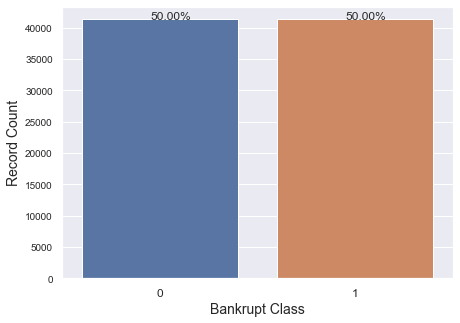

In [42]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
# summarize class distribution
print(Counter(data['class']))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(data, data['class'])
# summarize class distribution
print(Counter(y_over))
 
# plot the result after doing Random Oversampling
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=y_over,data=X_over)
plt.xticks(size=12)
plt.xlabel("Bankrupt Class", size=14)
plt.yticks(size=10)
plt.ylabel("Record Count", size=14)
 
without_hue(ax, y_over)

correlation matrix of attributes

<AxesSubplot:>

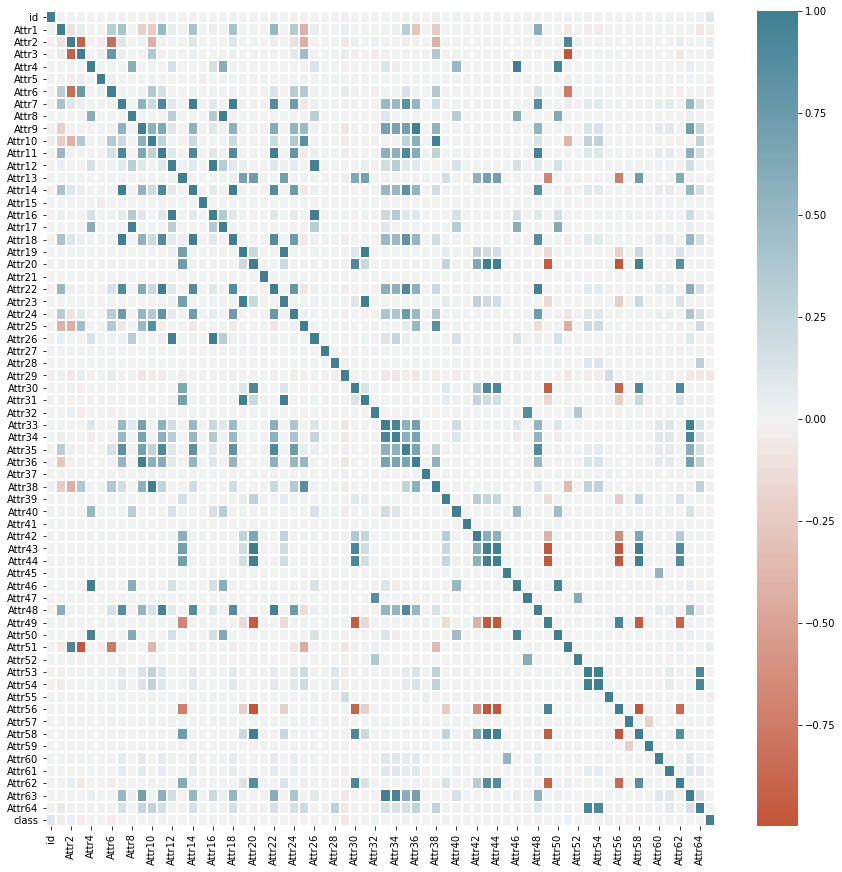

In [38]:
corrmat = data.corr()
f, ax =  plt.subplots(figsize=(15, 15))
sns.heatmap(corrmat, ax=ax, cmap=sns.diverging_palette(20, 220, n=200), linewidths=0.1 )

Preprocessing and normalizing data

In [ ]:
def preprocess_inputs(df, sampling_method=None):
    if sampling_method == "oversampling":
        df = randomoversampling(df)

    y = df['class'].to_numpy()
    X = df.drop(['class','id'], axis = 1)
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    np_scaled = min_max_scaler.fit_transform(X)
    return np_scaled, y

Performing K-fold test to get the accuracy on all models

In [62]:
def KfoldTest_testing_data(model, modelName, X, y):
    print("Performing K fold for: "+ modelName)
    cv = KFold(n_splits=10, random_state=42, shuffle=True)
    scores = []
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
    return np.mean(scores)

In [63]:
def KfoldTest_training_data(model, modelName, X, y):
    print("Performing K fold for: "+ modelName)
    cv = KFold(n_splits=10, random_state=42, shuffle=True)
    scores = []
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_train, y_train))
    return np.mean(scores)

In [132]:
original_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "RandomForestClassifier" :  RandomForestClassifier(),
    "Decision Tree" : DecisionTreeClassifier(),
    "K-nearest neighbors" : KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder =False,base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, n_estimators=100, n_jobs=1,
              nthread=None, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1,eval_metric='mlogloss')
}
print("K-fold cross validation with Oversampled data")
scaledData, y = preprocess_inputs(data, "oversampling")
for name, model in original_models.items():
    print("mean accuracy = " + str(KfoldTest_testing_data(model, name, scaledData, y)))
print("*************************************")

print("K-fold cross validation without sampling of data")
scaledData, y = preprocess_inputs(data)
for name, model in original_models.items():
    print("mean accuracy = " + str(KfoldTest_testing_data(model, name, scaledData, y)))   

K-fold cross validation with Oversampled data
Performing K fold for: SVM


Training accuracy

In [72]:
train_x,train_y = preprocess_inputs(data)
for name, model in original_models.items():
    model.fit(train_x,train_y)
    print(name + " trained.")
for name, model in original_models.items():
    result = model.score(train_x,train_y)
    print(name + ": {:.2f}%".format(result * 100))

Logistic Regression trained.
RandomForestClassifier trained.
Decision Tree trained.
K-nearest neighbors trained.
Gradient Boosting trained.
XGBoost trained.
Logistic Regression: 95.18%
RandomForestClassifier: 100.00%
Decision Tree: 100.00%
K-nearest neighbors: 95.38%
Gradient Boosting: 96.66%
XGBoost: 98.55%
C:\Users\bhagy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Train and Test accuracy plot

In [22]:
import plotly.graph_objects as go

models = ['LogisticRegression', 'RandomForestClassifier','K-NearestNeighbor','XGBoost','Decision Tree','Gradient Boosting','CART']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=models,
    y=[95.18, 100.00, 95.38,98.55,100.00,96.66,96.55],
    name='Training accuracy',
    marker_color='blue'
))
fig.add_trace(go.Bar(
    x=models,
    y=[66.89, 99.82, 95.46,99.99,99.83,99.99,96.00],
    name='Test accuracy',
    marker_color='lightskyblue'))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Model Names")
fig.update_yaxes(title_text="Model Accuracy")
#fig.update_traces(texttemplate=y%,textposition='outside')
#fig.update_layout(title_text = "Train and Test accuracy")
fig.update_layout(
    autosize=False,
    width=800,
    height=500)
fig.update_yaxes(automargin=True)
fig.show()

K-fold cross validation accuracy plot using oversampled data and without oversampled data

In [37]:
import plotly.graph_objects as go

models = ['LogisticRegression', 'RandomForestClassifier','K-NearestNeighbor','XGBoost','Decision Tree','Gradient Boosting','CART']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=models,
    y=[55.17, 99.62, 94.21,97.55,98.57,85.56],
    name='K-fold with oversampling data',
    marker_color='darkslateblue'
))
fig.add_trace(go.Bar(
    x=models,
    y=[95.18, 96.17, 95.07,97.59,94.58,96.44],
    name='K-fold without oversampling data',
    marker_color='cornflowerblue'))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Model Names")
fig.update_yaxes(title_text="Model Accuracy")
#fig.update_traces(texttemplate=y%,textposition='outside')
#fig.update_layout(title_text = "Train and Test accuracy")
fig.update_layout(
    autosize=False,
    width=800,
    height=500)
fig.update_yaxes(automargin=True)
fig.show()

Preprocessing of data by splitting data by 70:30 ratios to test accuracy using confusion matrix

In [1]:
def preprocess_data_confusion_matrix(df):
    bankrupt = df[df['class']==1]
    non_bankrupt = df[df['class']==0]
    # Normal_sample = Normal.sample(n=len(Fraud))
    sampled = bankrupt.sample(n=len(non_bankrupt), replace=True)
    df = sampled.append(non_bankrupt)
    y = df['class']
    X = df.drop(['class'], axis = 1)
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    #scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns) #creating dataframe & combining x_traindata
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns) #creating dataframe & combining x_test data
    return X_train, X_test, y_train, y_test


In [4]:
X_train, X_test, y_train, y_test = preprocess_data_confusion_matrix(data)

Logistic Regression trained.
Logistic Regression: 66.95%


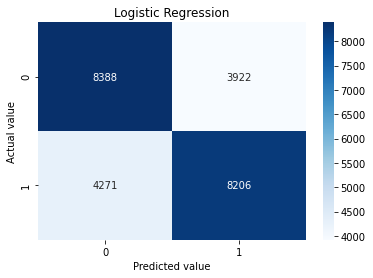

RandomForestClassifier trained.
RandomForestClassifier: 99.82%


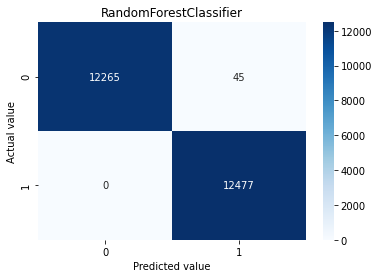

Decision Tree trained.
Decision Tree: 99.73%


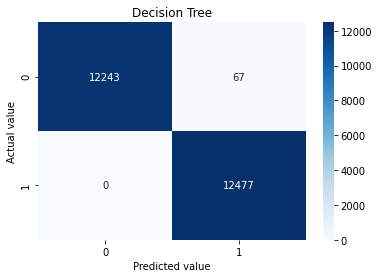

K-nearest neighbors trained.
K-nearest neighbors: 95.47%


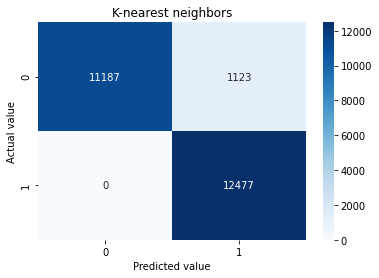

Gradient Boosting trained.
Gradient Boosting: 100.00%


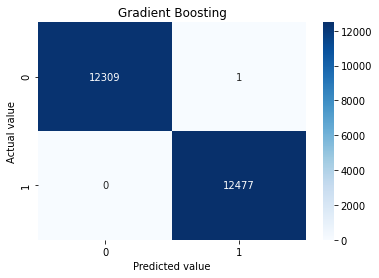

XGBoost trained.
XGBoost: 100.00%
C:\Users\bhagy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

C:\Users\bhagy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



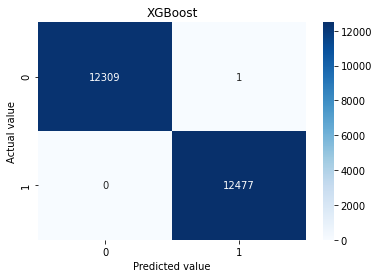

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

cm_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "RandomForestClassifier" : RandomForestClassifier(),
    "Decision Tree" : DecisionTreeClassifier(),
    "K-nearest neighbors" : KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss',use_label_encoder =False)
}
reports = {}
for name, model in cm_models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")
    result = model.score(X_test,y_test)
    print(name + ": {:.2f}%".format(result * 100))
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    reports[name] =  classification_report(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cbar=True,cmap='Blues')
    plt.title(name)
    plt.savefig(name)
    plt.ylabel('Actual value')
    plt.xlabel('Predicted value')
    plt.show()

F1 score, precision, recall results

In [24]:
for model_name in reports:
    print("Report for: " + model_name)
    print(reports[model_name])

Report for: Logistic Regression
              precision    recall  f1-score   support

           0       0.66      0.68      0.67     12310
           1       0.68      0.66      0.67     12477

    accuracy                           0.67     24787
   macro avg       0.67      0.67      0.67     24787
weighted avg       0.67      0.67      0.67     24787

Report for: RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12310
           1       1.00      1.00      1.00     12477

    accuracy                           1.00     24787
   macro avg       1.00      1.00      1.00     24787
weighted avg       1.00      1.00      1.00     24787

Report for: Decision Tree
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     12310
           1       0.99      1.00      1.00     12477

    accuracy                           1.00     24787
   macro avg       1.00      1.00  